# Detekcja Samochodów Przemytników - System Anomalii RTG

Ten notebook implementuje system detekcji anomalii w zdjęciach RTG samochodów przejeżdżających przez granicę.

## Pipeline:
1. **Preprocessing**: Ujednolicenie rozmiaru, korekcja orientacji, podział na kafelki
2. **Izolacja normalności**: Przygotowanie zbiorów treningowych
3. **Model**: Autoencoder do uczenia reprezentacji normalności
4. **Detekcja**: Obliczanie mapy błędu i lokalizacja anomalii
5. **Wizualizacja**: Zaznaczanie wykrytych obszarów

## 1. Importy i Konfiguracja

In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

# Sklearn
from sklearn.model_selection import train_test_split

# Sprawdzenie GPU
device = torch.device('cuda' if torch.cuda.is_available() 
                      else torch.device('mps') if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

# Ustawienia
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Ścieżki
DATA_INITIAL_DIR = Path('./NAUKA')
PROCESSED_DIR = Path('./processed')
PROCESSED_CLEAN_DIR = PROCESSED_DIR / 'czyste'
PROCESSED_ANOMALY_DIR = PROCESSED_DIR / 'brudne'

# Parametry obrazów
TARGET_WIDTH = 512
TARGET_HEIGHT = 512
BACKGROUND_COLOR = 245  # #f5f5f5

Using device: mps


## 2. Preprocessing - Pipeline data_initial/ → processed/

In [45]:
def crop_white_background(image_path, threshold=240, padding=5, background_ratio=0.95, edge_scan_depth=10):
    """
    Przycina obraz w skali szarości usuwając białe tło.
    
    Args:
        image_path: Ścieżka do obrazu lub sam obraz (numpy array)
        threshold: Próg jasności - piksele jaśniejsze niż ta wartość są uważane za tło (0-255)
        padding: Dodatkowy margines wokół zawartości (w pikselach)
        background_ratio: Jaki procent pikseli w rzędzie/kolumnie musi być tłem, aby uznać ją za pustą (0-1)
        edge_scan_depth: Ile kolejnych rzędów/kolumn od krawędzi musi być tłem, aby uznać je za puste
    
    Returns:
        Przycięty obraz (numpy array)
    """
    
    if isinstance(image_path, str):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Nie można wczytać obrazu: {image_path}")
    else:
        img = image_path
    
    h, w = img.shape
    
    # Znajdź maski tła
    background_mask = img >= threshold
    
    # Sprawdź każdy rząd - ile procent to tło
    row_background_ratio = background_mask.mean(axis=1)
    
    # Sprawdź każdą kolumnę - ile procent to tło
    col_background_ratio = background_mask.mean(axis=0)
    
    # Znajdź pierwszy rząd z góry, od którego zaczyna się zawartość
    # Ignorujemy pojedyncze odstające piksele przy krawędziach
    y_min = 0
    i = 0
    while i < h - edge_scan_depth:
        # Sprawdź następne edge_scan_depth rzędów
        next_rows = row_background_ratio[i:i+edge_scan_depth]
        # Jeśli większość (co najmniej 70%) to tło, uznaj za tło
        if np.sum(next_rows >= background_ratio) >= edge_scan_depth * 0.7:
            y_min = i + edge_scan_depth
            i += edge_scan_depth
        else:
            break
    
    # Znajdź ostatni rząd od dołu
    y_max = h
    i = h - 1
    while i >= edge_scan_depth:
        start_idx = max(0, i - edge_scan_depth + 1)
        prev_rows = row_background_ratio[start_idx:i+1]
        if np.sum(prev_rows >= background_ratio) >= edge_scan_depth * 0.7:
            y_max = start_idx
            i -= edge_scan_depth
        else:
            break
    
    # Znajdź pierwszą kolumnę z lewej
    x_min = 0
    i = 0
    while i < w - edge_scan_depth:
        next_cols = col_background_ratio[i:i+edge_scan_depth]
        if np.sum(next_cols >= background_ratio) >= edge_scan_depth * 0.7:
            x_min = i + edge_scan_depth
            i += edge_scan_depth
        else:
            break
    
    # Znajdź ostatnią kolumnę z prawej
    x_max = w
    i = w - 1
    while i >= edge_scan_depth:
        start_idx = max(0, i - edge_scan_depth + 1)
        prev_cols = col_background_ratio[start_idx:i+1]
        if np.sum(prev_cols >= background_ratio) >= edge_scan_depth * 0.7:
            x_max = start_idx
            i -= edge_scan_depth
        else:
            break
    
    # Dodaj padding
    y_min = max(0, y_min - padding)
    y_max = min(h, y_max + padding)
    x_min = max(0, x_min - padding)
    x_max = min(w, x_max + padding)
    
    # Przytnij obraz
    cropped = img[y_min:y_max, x_min:x_max]
    
    return cropped

def detect_and_orient_car(img):
    h, w = img.shape
    
    density_map = (255.0 - img) / 255.0
    
    D = density_map[h//2:, :] 
    h_D, w_D = D.shape
    
    x_coords = np.arange(w_D)
    
    weighted_sum = np.sum(D)
    
    if weighted_sum == 0:
        return img 
        
    x_centroid = np.sum(D * x_coords) / weighted_sum
    
    if x_centroid < w_D / 2.0:
        return cv2.flip(img, 1)
    return img


def resize_and_pad(img, target_w=896, target_h=320, bg_color=245):
    """
    Resize z zachowaniem proporcji i padding od lewej/prawej i góry
    Auto jest wyrównane do dolnej krawędzi (jak stoi na ziemi)
    
    Args:
        img: Obraz w skali szarości (numpy array)
        target_w: Docelowa szerokość
        target_h: Docelowa wysokość
        bg_color: Kolor tła (0-255)
    
    Returns:
        Obraz o rozmiarze (target_h, target_w) z wycentrowanym autem
    """
    h, w = img.shape
    
    # Oblicz skalę zachowującą proporcje
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    # Resize z zachowaniem proporcji
    img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)
    
    # Utwórz canvas z tłem
    img_final = np.full((target_h, target_w), bg_color, dtype=np.uint8)
    
    # Oblicz pozycję: wycentrowane poziomo, wyrównane do dołu pionowo
    x_offset = (target_w - new_w) // 2  # Wycentrowanie poziome
    y_offset = target_h - new_h  # Wyrównanie do dołu (auto stoi na ziemi)
    
    # Wklej przeskalowany obraz
    img_final[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = img_resized
    
    return img_final


def process_raw_images(source_dir, output_dir):
    """
    Pełny pipeline: data_initial/ -> processed/
    - Filtruje pliki z 'czarno' w nazwie
    - Crop białych marginesów
    - Orientacja (przód po prawej)
    - Resize do TARGET_WIDTH x TARGET_HEIGHT
    - Padding od lewej/prawej/góry (auto wyrównane do dołu)
    """
    source_path = Path(source_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Znajdź wszystkie pliki z "czarno"
    all_files = []
    for root, dirs, files in os.walk(source_path):
        for file in files:
            if "czarno" in file.lower() and file.endswith('.bmp'):
                file_path = Path(root) / file
                
                # Określ kategorię
                if "brudne" in root:
                    category = "brudne"
                elif "czyste" in root:
                    category = "czyste"
                else:
                    continue
                
                all_files.append((file_path, category, file))
    
    if not all_files:
        print(f"Brak plików w {source_dir}")
        return
    
    print(f"Znaleziono {len(all_files)} plików")
    
    stats = {"czyste": 0, "brudne": 0}
    
    for i, (img_path, category, filename) in enumerate(all_files, 1):
        try:
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            
            img = crop_white_background(img)
            img = detect_and_orient_car(img)
            img = resize_and_pad(img, TARGET_WIDTH, TARGET_HEIGHT, BACKGROUND_COLOR)
            
            category_dir = output_path / category
            category_dir.mkdir(exist_ok=True)
            output_file = category_dir / filename
            cv2.imwrite(str(output_file), img)
            
            stats[category] += 1
            
            if i % 20 == 0:
                print(f"  [{i}/{len(all_files)}] {category}/{filename}")
                
        except Exception as e:
            print(f"  Błąd: {img_path.name}: {e}")
    
    print(f"\n✓ Przetworzono:")
    print(f"  Czyste: {stats['czyste']}")
    print(f"  Brudne: {stats['brudne']}")


# ===== URUCHOM PREPROCESSING =====
print("="*60)
print(f"PREPROCESSING: {TARGET_WIDTH}x{TARGET_HEIGHT}, padding #{BACKGROUND_COLOR:02x}")
print("="*60)
print(f"Źródło: {DATA_INITIAL_DIR}")
print(f"Cel: {PROCESSED_DIR}")
print()

process_raw_images(DATA_INITIAL_DIR, PROCESSED_DIR)

print(f"\n✓ Dane gotowe w: {PROCESSED_DIR}/")
print(f"  - {PROCESSED_CLEAN_DIR}/")
print(f"  - {PROCESSED_ANOMALY_DIR}/")

PREPROCESSING: 512x512, padding #f5
Źródło: NAUKA
Cel: processed

Znaleziono 138 plików
  [20/138] czyste/48001F003202511180058 czarno.bmp
  [20/138] czyste/48001F003202511180058 czarno.bmp
  [40/138] czyste/48001F003202511180071 czarno.bmp
  [40/138] czyste/48001F003202511180071 czarno.bmp
  [60/138] czyste/48001F003202511180053 czarno.bmp
  [60/138] czyste/48001F003202511180053 czarno.bmp
  [80/138] brudne/48001F003202511190108 czarno.bmp
  [80/138] brudne/48001F003202511190108 czarno.bmp
  [100/138] brudne/48001F003202511190032 czarno.bmp
  [100/138] brudne/48001F003202511190032 czarno.bmp
  [120/138] brudne/48001F003202511190110 czarno.bmp
  [120/138] brudne/48001F003202511190110 czarno.bmp

✓ Przetworzono:
  Czyste: 64
  Brudne: 74

✓ Dane gotowe w: processed/
  - processed/czyste/
  - processed/brudne/

✓ Przetworzono:
  Czyste: 64
  Brudne: 74

✓ Dane gotowe w: processed/
  - processed/czyste/
  - processed/brudne/


## 3. Przygotowanie Danych - Dataset i Split Train/Val

In [46]:
class CarXRayDataset(Dataset):
    """
    PyTorch Dataset dla obrazów RTG samochodów.
    Wczytuje przetworzone obrazy z folderu 'czyste' i transformuje je do tensora.
    """
    
    def __init__(self, image_paths, transform=None):
        """
        Args:
            image_paths: Lista ścieżek do obrazów
            transform: Transformacje torchvision
        """
        self.image_paths = image_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Wczytaj obraz w skali szarości
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            raise ValueError(f"Nie można wczytać obrazu: {img_path}")
        
        # Konwersja do PIL Image dla kompatybilności z torchvision
        img_pil = Image.fromarray(img)
        
        # Aplikuj transformacje
        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            # Domyślna transformacja: ToTensor + normalizacja [0, 1]
            img_tensor = TF.to_tensor(img_pil)
        
        return img_tensor


# Zbierz wszystkie ścieżki do obrazów "czystych"
clean_image_paths = sorted(list(PROCESSED_CLEAN_DIR.glob('*.bmp')))

print(f"Znaleziono {len(clean_image_paths)} czystych obrazów w {PROCESSED_CLEAN_DIR}")

if len(clean_image_paths) == 0:
    raise ValueError(f"Brak obrazów w {PROCESSED_CLEAN_DIR}. Uruchom najpierw sekcję 2 (preprocessing).")

Znaleziono 64 czystych obrazów w processed/czyste


In [47]:

train_paths, temp_paths = train_test_split(
    clean_image_paths, 
    test_size=0.30, 
    random_state=SEED,
    shuffle=True
)

# Drugi split: połowa z temp idzie do val, połowa do test (po 15% każdy)
val_paths, test_paths = train_test_split(
    temp_paths, 
    test_size=0.50, 
    random_state=SEED,
    shuffle=True
)

print(f"Podział danych (czystych):")
print(f"  Train: {len(train_paths)} obrazów ({len(train_paths)/len(clean_image_paths)*100:.1f}%)")
print(f"  Val:   {len(val_paths)} obrazów ({len(val_paths)/len(clean_image_paths)*100:.1f}%)")
print(f"  Test:  {len(test_paths)} obrazów ({len(test_paths)/len(clean_image_paths)*100:.1f}%)")
print(f"  Total: {len(clean_image_paths)} obrazów")

Podział danych (czystych):
  Train: 44 obrazów (68.8%)
  Val:   10 obrazów (15.6%)
  Test:  10 obrazów (15.6%)
  Total: 64 obrazów


In [48]:
# Definicja transformacji
# Obrazy są już w docelowym rozmiarze (896x320), więc tylko normalizacja
transform = transforms.Compose([
    transforms.ToTensor(),  # Konwersja PIL Image -> Tensor [0, 1]
    # Opcjonalnie: normalizacja do [-1, 1] lub standaryzacja
    # transforms.Normalize(mean=[0.5], std=[0.5])  # -> [-1, 1]
])

# Utworzenie datasetów
train_dataset = CarXRayDataset(train_paths, transform=transform)
val_dataset = CarXRayDataset(val_paths, transform=transform)
test_dataset = CarXRayDataset(test_paths, transform=transform)

print(f"\nDatasety PyTorch:")
print(f"  Train dataset: {len(train_dataset)} obrazów")
print(f"  Val dataset:   {len(val_dataset)} obrazów")
print(f"  Test dataset:  {len(test_dataset)} obrazów")

# Test: wczytaj jeden przykład
sample_img = train_dataset[0]
print(f"\nKształt tensora: {sample_img.shape}")  # Powinno być [1, 320, 896]
print(f"Zakres wartości: [{sample_img.min():.3f}, {sample_img.max():.3f}]")
print(f"Dtype: {sample_img.dtype}")


Datasety PyTorch:
  Train dataset: 44 obrazów
  Val dataset:   10 obrazów
  Test dataset:  10 obrazów

Kształt tensora: torch.Size([1, 512, 512])
Zakres wartości: [0.078, 1.000]
Dtype: torch.float32


In [49]:
# Utworzenie DataLoaderów
BATCH_SIZE = 4  # Mały batch size dla małego datasetu

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,  # Tasowanie dla treningu
    num_workers=0,  # 0 dla macOS z MPS, można zwiększyć na CPU/CUDA
    pin_memory=True if device.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,  # Bez tasowania dla walidacji
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,  # Bez tasowania dla testu
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"DataLoadery PyTorch:")
print(f"  Train loader: {len(train_loader)} batchy po {BATCH_SIZE} obrazów")
print(f"  Val loader:   {len(val_loader)} batchy po {BATCH_SIZE} obrazów")
print(f"  Test loader:  {len(test_loader)} batchy po {BATCH_SIZE} obrazów")

# Test: pobierz jeden batch
test_batch = next(iter(train_loader))
print(f"\nKształt batcha: {test_batch.shape}")  # Powinno być [BATCH_SIZE, 1, 320, 896]
print(f"Device: {device}")
print(f"\n✓ Dane gotowe do treningu!")

DataLoadery PyTorch:
  Train loader: 11 batchy po 4 obrazów
  Val loader:   3 batchy po 4 obrazów
  Test loader:  3 batchy po 4 obrazów

Kształt batcha: torch.Size([4, 1, 512, 512])
Device: mps

✓ Dane gotowe do treningu!


## 3.5. Augmentacja Danych - Zwiększenie Datasetu

Zastosujemy sprytne augmentacje specyficzne dla obrazów RTG samochodów:
- **Additive Noise**: Symulacja szumów detektora RTG
- **Gaussian Blur**: Różne poziomy ostrości skanów
- **Brightness/Contrast**: Różne ustawienia ekspozycji
- **Horizontal Shift**: Przesunięcia poziome (auto w różnych pozycjach)
- **Slight Rotation**: Drobne rotacje (nierówne ustawienie przy skanowaniu)

In [50]:
class XRayAugmentation:
    """
    Augmentacje specyficzne dla RTG samochodów
    Zachowują realizm fizyczny skanów RTG
    """
    
    @staticmethod
    def add_noise(img, noise_factor=0.05):
        """Gaussian noise - symulacja szumów detektora"""
        noise = torch.randn_like(img) * noise_factor
        noisy = img + noise
        return torch.clamp(noisy, 0.0, 1.0)
    
    @staticmethod
    def gaussian_blur(img, kernel_size=5):
        """Rozmycie - symulacja nieostrości"""
        if kernel_size % 2 == 0:
            kernel_size += 1
        return transforms.GaussianBlur(kernel_size=kernel_size, sigma=(0.1, 2.0))(img)
    
    @staticmethod
    def adjust_brightness(img, factor=None):
        """Zmiana jasności - różne ekspozycje RTG"""
        if factor is None:
            factor = np.random.uniform(0.8, 1.2)
        return torch.clamp(img * factor, 0.0, 1.0)
    
    @staticmethod
    def adjust_contrast(img, factor=None):
        """Zmiana kontrastu - różne napięcia RTG"""
        if factor is None:
            factor = np.random.uniform(0.8, 1.2)
        mean = img.mean()
        return torch.clamp((img - mean) * factor + mean, 0.0, 1.0)
    
    @staticmethod
    def slight_rotation(img, max_angle=3, bg_value=245/255):
        """Delikatna rotacja - nierówne ustawienie przy skanowaniu"""
        angle = np.random.uniform(-max_angle, max_angle)
        
        # Konwersja tensor -> PIL -> rotate -> tensor
        img_pil = transforms.ToPILImage()(img)
        rotated = transforms.functional.rotate(
            img_pil, 
            angle, 
            fill=int(bg_value * 255)
        )
        return transforms.ToTensor()(rotated)
    
    @staticmethod
    def random_augment(img, p=0.5):
        """Losowa kombinacja augmentacji"""
        augmented = img.clone()
        
        # Noise (50% szans)
        if np.random.random() < p:
            augmented = XRayAugmentation.add_noise(augmented, noise_factor=np.random.uniform(0.01, 0.05))
        
        # Blur (30% szans)
        if np.random.random() < p * 0.6:
            augmented = XRayAugmentation.gaussian_blur(augmented, kernel_size=np.random.choice([3, 5]))
        
        # Brightness (60% szans)
        if np.random.random() < p * 1.2:
            augmented = XRayAugmentation.adjust_brightness(augmented)
        
        # Contrast (60% szans)
        if np.random.random() < p * 1.2:
            augmented = XRayAugmentation.adjust_contrast(augmented)
        
        # Rotation (30% szans)
        if np.random.random() < p * 0.6:
            augmented = XRayAugmentation.slight_rotation(augmented, max_angle=2)
        
        return augmented


def create_augmented_dataset(original_paths, augmentation_factor=3, output_dir=None):
    """
    Tworzy augmentowane obrazy z istniejących
    
    Args:
        original_paths: Lista ścieżek do oryginalnych obrazów
        augmentation_factor: Ile augmentowanych wersji na 1 obraz
        output_dir: Gdzie zapisać (opcjonalnie, None = tylko w pamięci)
    
    Returns:
        Lista wszystkich ścieżek (oryginalne + augmentowane)
    """
    transform = transforms.ToTensor()
    all_paths = list(original_paths)
    
    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"Tworzenie augmentacji: {len(original_paths)} obrazów × {augmentation_factor} wersji")
    
    for img_path in tqdm(original_paths, desc="Augmentacja"):
        # Wczytaj obraz
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        img_pil = Image.fromarray(img)
        img_tensor = transform(img_pil)
        
        # Generuj augmentowane wersje
        for aug_idx in range(augmentation_factor):
            augmented = XRayAugmentation.random_augment(img_tensor, p=0.5)
            
            if output_dir:
                # Zapisz do pliku
                aug_filename = f"{img_path.stem}_aug{aug_idx}{img_path.suffix}"
                aug_path = output_dir / aug_filename
                
                # Konwersja tensor -> numpy -> zapisz
                aug_np = (augmented.squeeze().numpy() * 255).astype(np.uint8)
                cv2.imwrite(str(aug_path), aug_np)
                all_paths.append(aug_path)
    
    print(f"✓ Utworzono {len(all_paths)} obrazów (oryginalne + augmentowane)")
    return all_paths

In [51]:
# Dataset z augmentacją on-the-fly
class AugmentedCarXRayDataset(Dataset):
    """
    Dataset z augmentacją na żywo podczas treningu
    Każda epoka = różne augmentacje = większa różnorodność
    """
    
    def __init__(self, image_paths, transform=None, use_augmentation=True, aug_probability=0.5):
        """
        Args:
            image_paths: Lista ścieżek do obrazów
            transform: Bazowe transformacje (ToTensor)
            use_augmentation: Czy stosować augmentację
            aug_probability: Prawdopodobieństwo augmentacji (0-1)
        """
        self.image_paths = image_paths
        self.transform = transform
        self.use_augmentation = use_augmentation
        self.aug_probability = aug_probability
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Wczytaj obraz
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Nie można wczytać obrazu: {img_path}")
        
        img_pil = Image.fromarray(img)
        
        # Bazowa transformacja
        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            img_tensor = TF.to_tensor(img_pil)
        
        # Augmentacja (tylko dla treningu)
        if self.use_augmentation:
            img_tensor = XRayAugmentation.random_augment(img_tensor, p=self.aug_probability)
        
        return img_tensor


# Przetworzenie datasetu z augmentacją ON-THE-FLY
print("="*60)
print("TWORZENIE DATASETÓW Z AUGMENTACJĄ ON-THE-FLY")
print("="*60)

# Datasety z augmentacją
train_dataset_aug = AugmentedCarXRayDataset(
    train_paths, 
    transform=transform, 
    use_augmentation=True,  # Augmentacja dla treningu
    aug_probability=0.2     # 20% szans na augmentację
)

val_dataset_aug = AugmentedCarXRayDataset(
    val_paths, 
    transform=transform, 
    use_augmentation=False  # BEZ augmentacji dla walidacji
)

test_dataset_aug = AugmentedCarXRayDataset(
    test_paths, 
    transform=transform, 
    use_augmentation=False  # BEZ augmentacji dla testu
)

print(f"\nDatasety z augmentacją:")
print(f"  Train: {len(train_dataset_aug)} obrazów (augmentacja ON)")
print(f"  Val:   {len(val_dataset_aug)} obrazów (augmentacja OFF)")
print(f"  Test:  {len(test_dataset_aug)} obrazów (augmentacja OFF)")

# DataLoadery z augmentacją
train_loader_aug = DataLoader(
    train_dataset_aug, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

val_loader_aug = DataLoader(
    val_dataset_aug, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

test_loader_aug = DataLoader(
    test_dataset_aug, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"\nDataLoadery z augmentacją:")
print(f"  Train: {len(train_loader_aug)} batchy (z augmentacją)")
print(f"  Val:   {len(val_loader_aug)} batchy (bez augmentacji)")
print(f"  Test:  {len(test_loader_aug)} batchy (bez augmentacji)")

print("\n✓ Datasety z augmentacją gotowe!")

TWORZENIE DATASETÓW Z AUGMENTACJĄ ON-THE-FLY

Datasety z augmentacją:
  Train: 44 obrazów (augmentacja ON)
  Val:   10 obrazów (augmentacja OFF)
  Test:  10 obrazów (augmentacja OFF)

DataLoadery z augmentacją:
  Train: 11 batchy (z augmentacją)
  Val:   3 batchy (bez augmentacji)
  Test:  3 batchy (bez augmentacji)

✓ Datasety z augmentacją gotowe!


## 4. Model Autoencodera

Uczenie reprezentacji normalności za pomocą Convolutional Autoencoder.

In [52]:
class ConvAutoencoder(nn.Module):
    """
    Autoencoder dla obrazów 512x512
    Input: [B, 1, 512, 512]
    Bottleneck: [B, latent_channels, 64, 64] (8x downsampling)
    Output: [B, 1, 512, 512]
    """
    
    def __init__(self, latent_channels=8, dropout_rate=0.1, noise_std=0.01, training=True):
        super(ConvAutoencoder, self).__init__()
        self.noise_std = noise_std
        self.training_mode = training
        
        # Encoder - 3 bloki (512x512 -> 64x64)
        self.encoder = nn.Sequential(
            # Blok 1: 512x512 -> 256x256
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            
            # Blok 2: 256x256 -> 128x128
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            
            # Blok 3: 128x128 -> 64x64 (BOTTLENECK)
            nn.Conv2d(32, latent_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(latent_channels),
        )
        
        self.bottleneck_dropout = nn.Dropout2d(p=dropout_rate)
        
        # Decoder - 3 bloki (64x64 -> 512x512)
        self.decoder = nn.Sequential(
            # Blok 1: 64x64 -> 128x128
            nn.ConvTranspose2d(latent_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            
            # Blok 2: 128x128 -> 256x256
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            
            # Blok 3: 256x256 -> 512x512
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def add_noise(self, x):
        """Dodaje Gaussian noise do bottleneck (tylko podczas treningu)"""
        if self.training and self.noise_std > 0:
            noise = torch.randn_like(x) * self.noise_std
            return x + noise
        return x
    
    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        
        # Bottleneck z noise i dropout (tylko podczas treningu)
        if self.training:
            encoded = self.add_noise(encoded)
            encoded = self.bottleneck_dropout(encoded)
        
        # Decode
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

# Inicjalizacja modelu
model = ConvAutoencoder(
    latent_channels=24,
    dropout_rate=0.05,
    noise_std=0.01,
    training=True
).to(device)

# Statystyki
total_params = sum(p.numel() for p in model.parameters())
input_size = TARGET_HEIGHT * TARGET_WIDTH  # 512 * 512
bottleneck_size = 24 * (TARGET_HEIGHT//8) * (TARGET_WIDTH//8)  # 24 * 64 * 64
compression_ratio = input_size / bottleneck_size

print(f"Model Architecture for {TARGET_HEIGHT}×{TARGET_WIDTH} images:")
print(f"  Parameters: {total_params:,}")
print(f"  Input size: {input_size:,} pixels")
print(f"  Bottleneck: {bottleneck_size:,} values")
print(f"  Compression: {compression_ratio:.1f}:1")

Model Architecture for 512×512 images:
  Parameters: 41,833
  Input size: 262,144 pixels
  Bottleneck: 98,304 values
  Compression: 2.7:1


In [53]:
# Funkcja treningowa
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        batch = batch.to(device)
        
        # Forward pass
        output = model(batch)
        loss = criterion(output, batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

class CombinedLoss(nn.Module):
    def __init__(self, mse_weight=0.7, l1_weight=0.3):
        super().__init__()
        self.mse = nn.MSELoss()
        self.l1 = nn.L1Loss()
        self.mse_weight = mse_weight
        self.l1_weight = l1_weight
    
    def forward(self, output, target):
        return (self.mse_weight * self.mse(output, target) + 
                self.l1_weight * self.l1(output, target))

criterion = CombinedLoss(mse_weight=0.6, l1_weight=0.4)

optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.0003,
    weight_decay=3e-4
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    patience=10,
    factor=0.5
)

print("Training: LR=0.0001, L2=1e-3, patience=10")

Training: LR=0.0001, L2=1e-3, patience=10


In [54]:
# Trening modelu
NUM_EPOCHS = 150
best_val_loss = float('inf')
train_losses = []
val_losses = []

print("Rozpoczynam trening autoencodera...")
print(f"Liczba epok: {NUM_EPOCHS}\n")

for epoch in range(NUM_EPOCHS):
    # Trening
    train_loss = train_epoch(model, train_loader_aug, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Walidacja
    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Zapisz najlepszy model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_autoencoder.pth')
    
    # Raportowanie
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

print("\nTrening zakończony!")
print(f"Najlepsza val loss: {best_val_loss:.6f}")

# Załaduj najlepszy model
model.load_state_dict(torch.load('best_autoencoder.pth'))
print("Załadowano najlepszy model")

Rozpoczynam trening autoencodera...
Liczba epok: 150

Epoch [5/150] - Train Loss: 0.196737, Val Loss: 0.163688
Epoch [5/150] - Train Loss: 0.196737, Val Loss: 0.163688
Epoch [10/150] - Train Loss: 0.128632, Val Loss: 0.104683
Epoch [10/150] - Train Loss: 0.128632, Val Loss: 0.104683
Epoch [15/150] - Train Loss: 0.084994, Val Loss: 0.081954
Epoch [15/150] - Train Loss: 0.084994, Val Loss: 0.081954
Epoch [20/150] - Train Loss: 0.062147, Val Loss: 0.062638
Epoch [20/150] - Train Loss: 0.062147, Val Loss: 0.062638
Epoch [25/150] - Train Loss: 0.051831, Val Loss: 0.047861
Epoch [25/150] - Train Loss: 0.051831, Val Loss: 0.047861
Epoch [30/150] - Train Loss: 0.042520, Val Loss: 0.028224
Epoch [30/150] - Train Loss: 0.042520, Val Loss: 0.028224
Epoch [35/150] - Train Loss: 0.037079, Val Loss: 0.025371
Epoch [35/150] - Train Loss: 0.037079, Val Loss: 0.025371
Epoch [40/150] - Train Loss: 0.032552, Val Loss: 0.030173
Epoch [40/150] - Train Loss: 0.032552, Val Loss: 0.030173
Epoch [45/150] - Tra

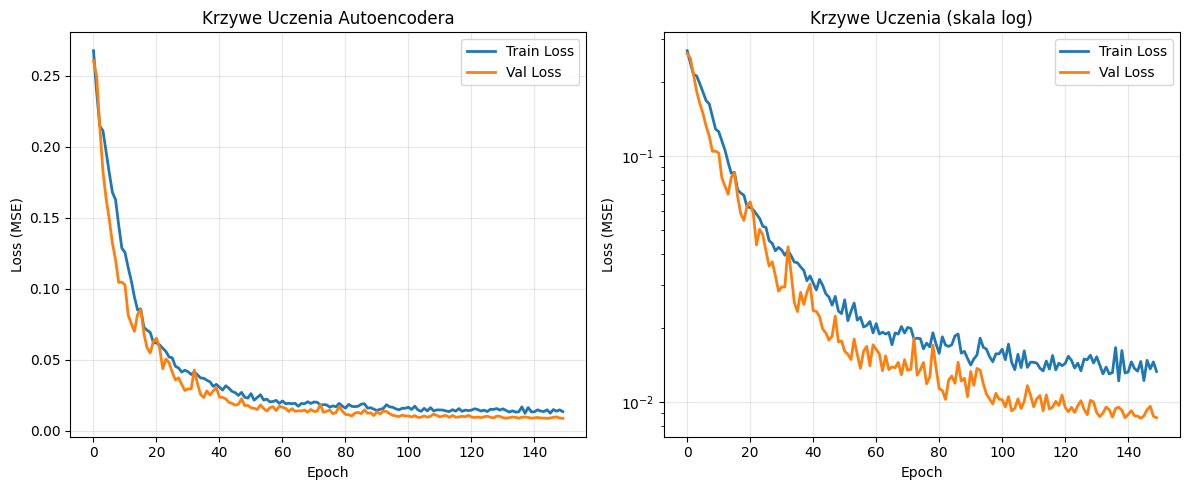

In [55]:
# Wizualizacja krzywych uczenia
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Krzywe Uczenia Autoencodera')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Krzywe Uczenia (skala log)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Ustalenie Progu Anomalii (τ) - Krok 6

Obliczamy błąd rekonstrukcji na zbiorze walidacyjnym i ustalamy optymalny próg.

Błędy rekonstrukcji na zbiorze walidacyjnym:
  Średnia: 0.002384
  Std. dev: 0.000163
  95-ty percentyl: 0.002624
  99-ty percentyl: 0.002663

✓ Ustalony próg anomalii τ = 0.003994


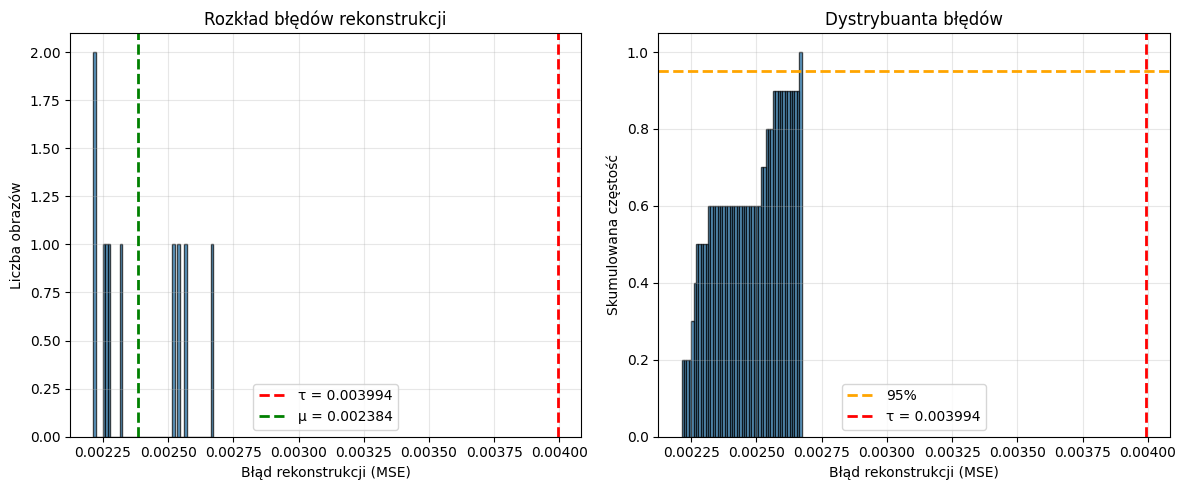

In [56]:
def compute_reconstruction_errors(model, dataloader, device):
    """Oblicza błędy rekonstrukcji dla całego datasetu"""
    model.eval()
    errors = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)
            
            # Błąd per obraz (MSE)
            batch_errors = torch.mean((batch - output) ** 2, dim=[1, 2, 3])
            errors.extend(batch_errors.cpu().numpy())
    
    return np.array(errors)

# Oblicz błędy na zbiorze walidacyjnym
val_errors = compute_reconstruction_errors(model, val_loader, device)

# Statystyki
mean_error = np.mean(val_errors)
std_error = np.std(val_errors)
percentile_95 = np.percentile(val_errors, 95)
percentile_99 = np.percentile(val_errors, 99)

print("Błędy rekonstrukcji na zbiorze walidacyjnym:")
print(f"  Średnia: {mean_error:.6f}")
print(f"  Std. dev: {std_error:.6f}")
print(f"  95-ty percentyl: {percentile_95:.6f}")
print(f"  99-ty percentyl: {percentile_99:.6f}")

# Ustal próg τ jako 95-ty percentyl + margines
tau = percentile_99 * 1.5  # Margines bezpieczeństwa (zwiększony dla mniejszej czułości)
print(f"\n✓ Ustalony próg anomalii τ = {tau:.6f}")

# Wizualizacja rozkładu błędów
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(val_errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(tau, color='red', linestyle='--', linewidth=2, label=f'τ = {tau:.6f}')
plt.axvline(mean_error, color='green', linestyle='--', linewidth=2, label=f'μ = {mean_error:.6f}')
plt.xlabel('Błąd rekonstrukcji (MSE)')
plt.ylabel('Liczba obrazów')
plt.title('Rozkład błędów rekonstrukcji')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(val_errors, bins=50, edgecolor='black', alpha=0.7, cumulative=True, density=True)
plt.axhline(0.95, color='orange', linestyle='--', linewidth=2, label='95%')
plt.axvline(tau, color='red', linestyle='--', linewidth=2, label=f'τ = {tau:.6f}')
plt.xlabel('Błąd rekonstrukcji (MSE)')
plt.ylabel('Skumulowana częstość')
plt.title('Dystrybuanta błędów')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Detektor

In [57]:
class AnomalyDetector:
    """Detektor anomalii z lokalizacją"""
    
    def __init__(self, model, threshold, device):
        self.model = model
        self.threshold = threshold
        self.device = device
        self.model.eval()
    
    def compute_error_map(self, image_tensor):
        """
        Krok 7: Obliczenie mapy błędu lokalnego
        image_tensor: [1, H, W] torch.Tensor
        """
        with torch.no_grad():
            if image_tensor.dim() == 3:
                image_tensor = image_tensor.unsqueeze(0)
            
            image_tensor = image_tensor.to(self.device)
            reconstruction = self.model(image_tensor)
            
            error_map = (image_tensor - reconstruction) ** 2
            error_map = error_map.squeeze(0)
            reconstruction = reconstruction.squeeze(0)
        
        return error_map, reconstruction
    
    def create_anomaly_mask(self, error_map, percentile_threshold=98.5):
        """
        Krok 8: Progowanie mapy błędu (adaptywny próg per-obraz)
        error_map: [1, H, W] torch.Tensor
        percentile_threshold: Wyższy = mniej False Positives
        """
        # Normalizuj mapę błędu
        error_flat = error_map.flatten()
        error_min = error_flat.min()
        error_max = error_flat.max()
        error_map_normalized = (error_map - error_min) / (error_max - error_min + 1e-8)
        
        # Adaptywny próg z aktualnego obrazu
        error_np = error_map_normalized.cpu().numpy().flatten()
        local_threshold = np.percentile(error_np, percentile_threshold)
        
        # Maska binarna
        anomaly_mask = (error_map_normalized.squeeze() > local_threshold).float()
        mask_np = (anomaly_mask.cpu().numpy() * 255).astype(np.uint8)
        
        # Operacje morfologiczne - TYLKO OPEN (usuwa drobne szumy)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        mask_np = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel)
        mask_np = (mask_np > 127).astype(np.uint8)
        
        return mask_np
    
    def find_bounding_boxes(self, anomaly_mask, min_area=300):
        """
        Krok 9-10: Grupowanie komponentów i bounding boxes
        min_area: Minimalny rozmiar regionu (piksel^2)
        """
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            anomaly_mask, connectivity=8
        )
        
        bounding_boxes = []
        
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            
            if area >= min_area:
                x = stats[i, cv2.CC_STAT_LEFT]
                y = stats[i, cv2.CC_STAT_TOP]
                w = stats[i, cv2.CC_STAT_WIDTH]
                h = stats[i, cv2.CC_STAT_HEIGHT]
                
                # Filtruj zbyt wydłużone regiony (linie, artefakty)
                aspect_ratio = max(w, h) / (min(w, h) + 1e-6)
                if aspect_ratio > 8:
                    continue
                
                bounding_boxes.append({
                    'x': x, 'y': y, 'width': w, 'height': h,
                    'area': area,
                    'centroid': centroids[i],
                    'aspect_ratio': aspect_ratio
                })
        
        return bounding_boxes
    
    def detect_and_localize(self, image_tensor, percentile_threshold=98.5, min_area=300):
        """
        Pełny pipeline detekcji i lokalizacji
        
        Args:
            image_tensor: [1, H, W] torch.Tensor
            percentile_threshold: Próg percentyla (98.5 = top 1.5% błędów)
            min_area: Minimalny rozmiar wykrywanego regionu
        
        Returns:
            dict: Wyniki detekcji
        """
        error_map, reconstruction = self.compute_error_map(image_tensor)
        anomaly_mask = self.create_anomaly_mask(error_map, percentile_threshold)
        bounding_boxes = self.find_bounding_boxes(anomaly_mask, min_area)
        
        global_error = error_map.mean().item()
        
        # Decyzja: anomalia jeśli:
        # 1. Wysoki błąd globalny I są boxy, LUB
        # 2. Co najmniej 3 boxy (niezależnie od błędu)
        is_anomaly = (global_error > self.threshold and len(bounding_boxes) > 0) or \
                     len(bounding_boxes) >= 3
        
        return {
            'is_anomaly': is_anomaly,
            'global_error': global_error,
            'error_map': error_map.cpu(),
            'reconstruction': reconstruction.cpu(),
            'anomaly_mask': anomaly_mask,
            'bounding_boxes': bounding_boxes
        }
    
    def visualize_detection(self, original_tensor, detection_result):
        """Krok 11: Wizualizacja wyniku"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        orig_np = original_tensor.squeeze().cpu().numpy()
        recon_np = detection_result['reconstruction'].squeeze().numpy()
        error_np = detection_result['error_map'].squeeze().numpy()
        
        # Oryginał
        axes[0, 0].imshow(orig_np, cmap='gray')
        axes[0, 0].set_title(f'Oryginał RTG\n{orig_np.shape[0]}×{orig_np.shape[1]}')
        axes[0, 0].axis('off')
        
        # Rekonstrukcja
        axes[0, 1].imshow(recon_np, cmap='gray')
        axes[0, 1].set_title('Rekonstrukcja')
        axes[0, 1].axis('off')
        
        # Mapa błędu
        im = axes[0, 2].imshow(error_np, cmap='hot')
        axes[0, 2].set_title('Mapa błędu lokalnego')
        axes[0, 2].axis('off')
        plt.colorbar(im, ax=axes[0, 2])
        
        # Maska anomalii
        axes[1, 0].imshow(detection_result['anomaly_mask'], cmap='gray')
        axes[1, 0].set_title('Maska anomalii')
        axes[1, 0].axis('off')
        
        # Overlay
        overlay = np.stack([orig_np, orig_np, orig_np], axis=-1)
        mask_overlay = detection_result['anomaly_mask'] > 0
        overlay[mask_overlay, 0] = 1.0
        axes[1, 1].imshow(overlay)
        axes[1, 1].set_title('Nałożona maska')
        axes[1, 1].axis('off')
        
        # Bounding boxes
        img_with_boxes = np.stack([orig_np, orig_np, orig_np], axis=-1)
        img_with_boxes = (img_with_boxes * 255).astype(np.uint8)
        
        for bbox in detection_result['bounding_boxes']:
            cv2.rectangle(
                img_with_boxes,
                (bbox['x'], bbox['y']),
                (bbox['x'] + bbox['width'], bbox['y'] + bbox['height']),
                (0, 255, 0), 3
            )
            
            label = f"A:{bbox['area']}"
            cv2.putText(
                img_with_boxes, label,
                (bbox['x'], bbox['y'] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2
            )
        
        axes[1, 2].imshow(img_with_boxes)
        title = f"Regiony: {len(detection_result['bounding_boxes'])}\n"
        title += f"Błąd: {detection_result['global_error']:.6f}"
        axes[1, 2].set_title(title)
        axes[1, 2].axis('off')
        
        status = "⚠️ ANOMALIA!" if detection_result['is_anomaly'] else "✓ NORMALNY"
        color = 'red' if detection_result['is_anomaly'] else 'green'
        fig.suptitle(status, fontsize=18, fontweight='bold', color=color)
        
        plt.tight_layout()
        plt.show()

print("✓ Klasa AnomalyDetector gotowa!")

✓ Klasa AnomalyDetector gotowa!


In [58]:
# Inicjalizacja detektora z wytrenowanym modelem
detector = AnomalyDetector(model, tau, device)

print("✓ AnomalyDetector zainicjalizowany!")
print(f"  Model: ConvAutoencoder")
print(f"  Próg anomalii (τ): {tau:.6f}")
print(f"  Urządzenie: {device}")

✓ AnomalyDetector zainicjalizowany!
  Model: ConvAutoencoder
  Próg anomalii (τ): 0.003994
  Urządzenie: mps


## 8. Funkcja pod API

In [71]:
def process_xray_image(image_path, detector, visualize=True):
    """
    Przetwarzanie pojedynczego obrazu RTG z processed/
    
    Parameters:
    -----------
    image_path : str lub Path
        Ścieżka do przetworzonego obrazu RTG z processed/ (.bmp)
    detector : AnomalyDetector
        Wytrenowany detektor anomalii
    visualize : bool
        Czy pokazać wizualizację
    
    Returns:
    --------
    dict : Wyniki detekcji
    """
    img = Image.open(image_path).convert('L')
    to_tensor = transforms.ToTensor()
    img_tensor = to_tensor(img)
    
    # Detekcja z optymalnymi parametrami
    result = detector.detect_and_localize(
        img_tensor, 
        percentile_threshold=95,  # Top 1.5% błędów
        min_area=100                # Minimum 300 pikseli
    )
    
    # Przygotowanie wyniku
    output = {
        'is_smuggler': result['is_anomaly'],
        'confidence': result['global_error'],
        'num_suspicious_regions': len(result['bounding_boxes']),
        'bounding_boxes': result['bounding_boxes'],
        'recommendation': ''
    }
    
    # Rekomendacja
    if output['is_smuggler']:
        if output['num_suspicious_regions'] >= 3:
            output['recommendation'] = "🚨 ALARM - Wiele podejrzanych obszarów! Kontrola wymagana."
        elif output['num_suspicious_regions'] >= 2:
            output['recommendation'] = "⚠️ OSTRZEŻENIE - Podejrzane obszary. Zalecana kontrola."
        elif output['confidence'] > detector.threshold * 1.5:
            output['recommendation'] = "⚠️ UWAGA - Wysoki błąd rekonstrukcji. Weryfikacja."
        else:
            output['recommendation'] = "🔍 UWAGA - Niewielka anomalia. Możliwy false positive."
    else:
        output['recommendation'] = "✓ OK - Brak anomalii. Samochód może przejechać."
    
    if visualize:
        detector.visualize_detection(img_tensor, result)
        print(f"\n{output['recommendation']}")
        print(f"Pewność (błąd): {output['confidence']:.6f}")
        print(f"Wykryte regiony: {output['num_suspicious_regions']}")
    
    return output

print("✓ Funkcja process_xray_image gotowa!")
print("\nPrzykład użycia:")
print("result = process_xray_image('processed/czyste/48001F003202511180021 czarno.bmp', detector)")
print("result = process_xray_image('processed/brudne/48001F003202511190093 czarno.bmp', detector)")

✓ Funkcja process_xray_image gotowa!

Przykład użycia:
result = process_xray_image('processed/czyste/48001F003202511180021 czarno.bmp', detector)
result = process_xray_image('processed/brudne/48001F003202511190093 czarno.bmp', detector)


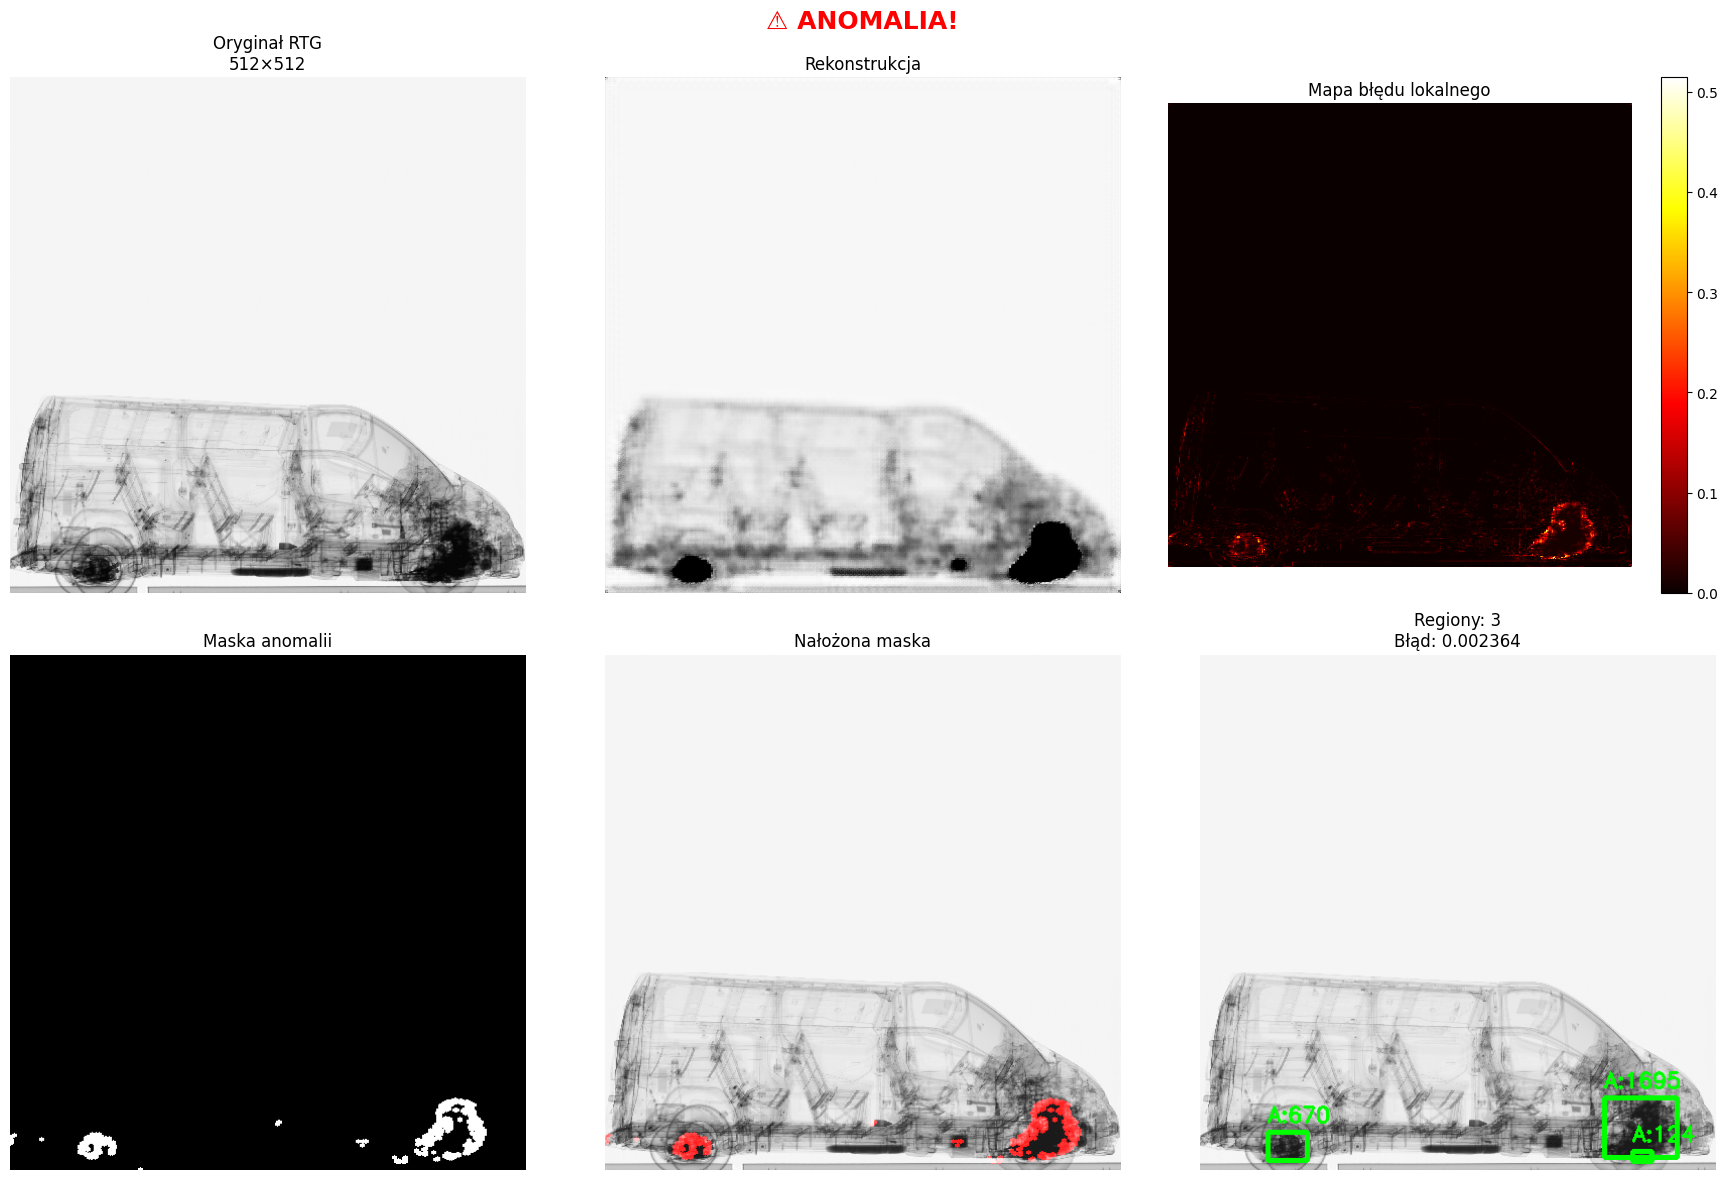


🚨 ALARM - Wiele podejrzanych obszarów! Kontrola wymagana.
Pewność (błąd): 0.002364
Wykryte regiony: 3


In [72]:
result = process_xray_image('processed/brudne/48001F003202511190093 czarno.bmp', detector)

## Zapisanie Modelu i Parametrów

Zapisz model i konfigurację do późniejszego użycia.

In [73]:
import json

# Zapisz model
torch.save({
    'model_state_dict': model.state_dict(),
    'threshold': tau,
    'model_config': {
        'latent_dim': 128,
        'target_size': (256, 256)
    },
    'training_stats': {
        'best_val_loss': best_val_loss,
        'final_train_loss': train_losses[-1] if train_losses else None,
        'num_epochs': NUM_EPOCHS
    }
}, 'smuggler_detector_model.pth')

# Zapisz konfigurację
config = {
    'threshold': float(tau),
    'target_size': [256, 256],
    'latent_dim': 128,
    'percentile_threshold': 95,
    'min_area': 50,
    'preprocessing': {
        'threshold': 250,
        'padding': 5
    }
}

with open('smuggler_detector_config.json', 'w') as f:
    json.dump(config, f, indent=4)

print("✓ Model zapisany: smuggler_detector_model.pth")
print("✓ Konfiguracja zapisana: smuggler_detector_config.json")
print("\nDo załadowania modelu użyj:")
print("""
model = ConvAutoencoder(latent_dim=128)
checkpoint = torch.load('smuggler_detector_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
tau = checkpoint['threshold']
detector = AnomalyDetector(model, tau, device)
""")

✓ Model zapisany: smuggler_detector_model.pth
✓ Konfiguracja zapisana: smuggler_detector_config.json

Do załadowania modelu użyj:

model = ConvAutoencoder(latent_dim=128)
checkpoint = torch.load('smuggler_detector_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
tau = checkpoint['threshold']
detector = AnomalyDetector(model, tau, device)

